In [ ]:
'''disabled learning rate decay'''

In [1]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [2]:
from coin_if import COINWrapper,read_COIN_params

In [3]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace
from custom_optimizers import ElementWiseDecay,GlobalPNormDecay   
from stat_utils import bic

In [4]:
#setting torch seeds
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True


In [5]:
# from coin_if import read_COIN_params
# raw_coin_params = read_COIN_params('/fitted_parameters/')

In [6]:
args = SimpleNamespace()
args.paradigm = ['evoked', 'spontaneous']

paradigm_short = {
    'evoked': 'E',
    'spontaneous': 'S'
}

paradigm_info = {
    'evoked': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous': {
        'i_min': 1,
        'i_max': 8,}
    }



In [7]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
# param_names = [k for k in raw_coin_params['E1'].keys()]

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            
            with open(f'{ROOT_PATH}/results/coin_{paradigm}_run062_MSE_{i}.pkl','rb') as f:
                opt_data[id] = pickle.load(f)
            # kk = paradigm_short[paradigm]+str(i)
            # opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_recovery_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

In [8]:
ref_opt_data = opt_data.copy()

In [9]:
def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict(n_inputs = 4,
                        n_hidden = 20*512,
                        n_outs = 1,
                        en_bias = False,
                        first_layer_init='uniform_unity',
                    first_layer_weights_trainable = False,
                    out_layer_init='zeros',
                        nl = 'relu')        

fixed_params['runner'] = {'criterion':'MSE', 'k':[0,0,0,1],  'sigma_noi':0.0, 'tau_u':1,
                        #   'filter_spec':{'tau_u_fb':10.0},
                        'save_model_at_init':False, 'ic_param_file':None, 'enable_combo':True, 'optimizer_class': GlobalPNormDecay}

optim_param_mapping= [('custom','log_lr'),
                    ('custom','alpha'),                                
                    ('model','b_high'),                      
                    ('postprocessing','scale'),
                    # ('custom','weight_decay'), 
                    ('custom','log_weight_decay'), 
                                        ]
custom_param_mappings = [{'cathegory':'runner','param_name':'learning_rate',
                            'fun': lambda x: 10.**x['log_lr']},
                            {'cathegory':'runner','param_name':'optimizer_opts',
                        'fun': lambda x: {'alpha': 0*x['alpha'], 'weight_decay': 10**x['log_weight_decay']} },]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [10]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)]}

# data = {}
# id = 0
# for , paradigm in paradigm_by_id_lut.items():
    
# stimulus = stimuli[args.paradigm]
datapoint_mapping=None

In [11]:
# optim_param_mapping= [('custom','log_lr'),
#                     ('custom','alpha'),                      
# #                     ('model','b_high'),                      
# #                     ('postprocessing','scale'),
# #                     ]

# custom_opt_data = { 
#     # 0: [-2.8,0.8, 0.14, 1.0],
#     # 0: [-4,0.7, 0.12, 1.0],
#     # 0: [-4.,0.7, 0.12, 0.9],
#     # 0: [-4.,0.7, 0.12, 0.93],
#     0: [-3.683e+00,  8.452e-01 , 1.009e-01 , 8.858e-01, 0],
#     # 0: [-4.6,0.7, 0.08, 1.0],
#     # 2: [-4.8,0.3, 0.22, 1.0],
#     }


# custom_opt_data = { 
#     k: [-3.683e+00,  8.452e-01 , 1.009e-01 , 8.858e-01, -4] for k in range(16)
#     }


# opt_data = ref_opt_data.copy()
# for k, v in custom_opt_data.items():
#     opt_data[k] = {'MSE': {'x': np.copy(v)}}

In [11]:
pooling_fun = 'MSE'

In [12]:
torch.manual_seed(0)

# outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}
# for k in custom_opt_data:
#     outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x'])  

In [13]:
# local optimisation of parameters with fixed seed=0

# define objective function
def objective_fun_wrapper(stimulus, target):
    def loss_fun(x):
        torch.manual_seed(0)
        out = wrapped_runner(stimulus, x)
        mse = np.nanmean((out - target) ** 2)
        return mse
    return loss_fun


In [14]:
#import local optimization method
from scipy.optimize import minimize



In [16]:
# opt_params = {}
# for k in opt_data:
#     print(f'Optimizing parameters for {k} with initial params {opt_data[k][pooling_fun]["x"]}')
#     opt_params[k] = minimize(objective_fun_wrapper(stimuli[paradigm_by_id_lut[k]], data[k]),
#                         opt_data[0][pooling_fun]['x'],
#                         method='Nelder-Mead',
#                         options={'maxiter': 100, 'disp': True})
#     print(f'Optimized parameters for {k}: {opt_params[k].x}')

In [17]:
# opt_params[2]['x']

In [15]:
import pickle
# with open('deleteme.2.pkl','wb') as f:
#     pickle.dump([opt_params,'lin scale weight decay, no learning slowdown relax. time'],f)

In [19]:
# locopt_data = {k: opt_params[k]['x'] for k in opt_params}

In [20]:
# locopt_data

In [21]:
# locopt_data_manu = {}
# locopt_data_manu[1] = [-4.8,  0.22,  0.135,  1.0, -5]
# locopt_data_manu[8] = [-5,  0.0,  0.20688669,  1.04411679, -2]

In [16]:
# opt_params_manu = {}
# for k in opt_data:
#     torch.manual_seed(0)
#     x0 = opt_data[k][pooling_fun]['x']
#     print(f'Optimizing parameters for {k} with initial params {x0}')
#     opt_params_manu[k] = minimize(objective_fun_wrapper(stimuli[paradigm_by_id_lut[k]], data[k]),
#                         x0,
#                         method='Nelder-Mead',
#                         # method='CG',
#                         options={'maxiter': 200, 'disp': True})
#     print(f'Optimized parameters for {k}: {opt_params_manu[k].x}, rmse: {np.sqrt(opt_params_manu[k].fun)}')

# #save opt_params_manu
# # with open(f'{ROOT_PATH}/experimental/opt_params_manu_COIN_run62locVanillaNoiseDebugLR.pkl','wb') as f:
# #     pickle.dump(opt_params_manu,f)

# recover params from file
with open(f'{ROOT_PATH}/experimental/opt_params_manu_COIN_run62locVanillaNoiseDebugLR.pkl','rb') as f:
    opt_params_manu = pickle.load(f)

In [23]:
opt_params_manu

{0:        message: Optimization terminated successfully.
        success: True
         status: 0
            fun: 0.008299226029911141
              x: [-3.668e+00  8.571e-01  1.003e-01  8.848e-01 -3.588e+00]
            nit: 125
           nfev: 243
  final_simplex: (array([[-3.668e+00,  8.571e-01, ...,  8.848e-01,
                         -3.588e+00],
                        [-3.668e+00,  8.571e-01, ...,  8.848e-01,
                         -3.588e+00],
                        ...,
                        [-3.668e+00,  8.571e-01, ...,  8.848e-01,
                         -3.588e+00],
                        [-3.668e+00,  8.571e-01, ...,  8.848e-01,
                         -3.588e+00]]), array([ 8.299e-03,  8.299e-03,  8.299e-03,  8.299e-03,
                         8.299e-03,  8.299e-03])),
 1:        message: Maximum number of iterations has been exceeded.
        success: False
         status: 2
            fun: 0.008705904722078257
              x: [-4.179e+00  5.731e-01  1.30

In [24]:
# for k in locopt_data_manu:
#     locopt_data[k] = locopt_data_manu[k]

In [17]:
outs = {}
for k in range(16):
    torch.manual_seed(0)
    # outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],locopt_data[k]) 
    # outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x'])
    # opt_params_manu
    outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_params_manu[k]['x'])



In [20]:
fixed_params_noi = fixed_params.copy()
fixed_params_noi['runner'].update({'noise_spec':{'noi_x': 0.0, 'noi_u': 0.1, 'noi_y': 0.0, 'noi_post_u': 0.1}})
wrapped_runner_noi = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params_noi,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)

In [18]:
fixed_params_noi_u = fixed_params.copy()
fixed_params_noi_u['runner'].update({'noise_spec':{'noi_x': 0.0, 'noi_u': 0.1, 'noi_y': 0.0, 'noi_post_u': 0.0}})
wrapped_runner_noi_u = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params_noi_u,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)

In [21]:
n_trials = 5
outs_noi = {}
for k in range(16):
    outs_noi[k] = []
    for n in range(n_trials):
    # torch.manual_seed(0)
    # outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],locopt_data[k]) 
    # outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x'])
    # opt_params_manu
        outs_noi[k].append(wrapped_runner_noi(stimuli[paradigm_by_id_lut[k]],opt_params_manu[k]['x'],seed=n))

In [68]:
outs_noi_u = {}
for k in range(16):
    print(f'Computing noisy outputs for k={k}')
    outs_noi_u[k] = []
    for n in range(n_trials):
    # torch.manual_seed(0)
    # outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],locopt_data[k]) 
    # outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x'])
    # opt_params_manu
        outs_noi_u[k].append(wrapped_runner_noi_u(stimuli[paradigm_by_id_lut[k]],opt_params_manu[k]['x'],seed=n))

Computing noisy outputs for k=0
Computing noisy outputs for k=1
Computing noisy outputs for k=2
Computing noisy outputs for k=3
Computing noisy outputs for k=4
Computing noisy outputs for k=5
Computing noisy outputs for k=6
Computing noisy outputs for k=7
Computing noisy outputs for k=8
Computing noisy outputs for k=9
Computing noisy outputs for k=10
Computing noisy outputs for k=11
Computing noisy outputs for k=12
Computing noisy outputs for k=13
Computing noisy outputs for k=14
Computing noisy outputs for k=15


In [ ]:
outs_noi_u_ = {}  #customised noi_u, using optimal point from the likelihood optimisation
for k in range(16):
    fixed_params_noi_u = fixed_params.copy()
    fixed_params_noi_u['runner'].update({'noise_spec':{'noi_x': 0.0, 'noi_u': 0.1*final_weights[k][0], 'noi_y': 0.0, 'noi_post_u': 0.0}})
    wrapped_runner_noi_u = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params_noi_u,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)
    print(f'Computing noisy outputs for k={k}')
    outs_noi_u_[k] = []
    for n in range(n_trials):
    # torch.manual_seed(0)
    # outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],locopt_data[k]) 
    # outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x'])
    # opt_params_manu
        outs_noi_u_[k].append(wrapped_runner_noi_u(stimuli[paradigm_by_id_lut[k]],opt_params_manu[k]['x'],seed=n))




Computing noisy outputs for k=0
Computing noisy outputs for k=1
Computing noisy outputs for k=2
Computing noisy outputs for k=3


In [92]:
len(outs_noi_u_)

16

In [ ]:
# #save outs_noi and outs to file named 'collect_fitting_info_COIN_run62locVanillaNoise<n>_trials.pkl'
# with open(f'{ROOT_PATH}/experimental/collect_fitting_info_COIN_run62locVanillaNoise300_trials.pkl','wb') as f:
#     pickle.dump([outs_noi, outs_noi_u, outs],f)

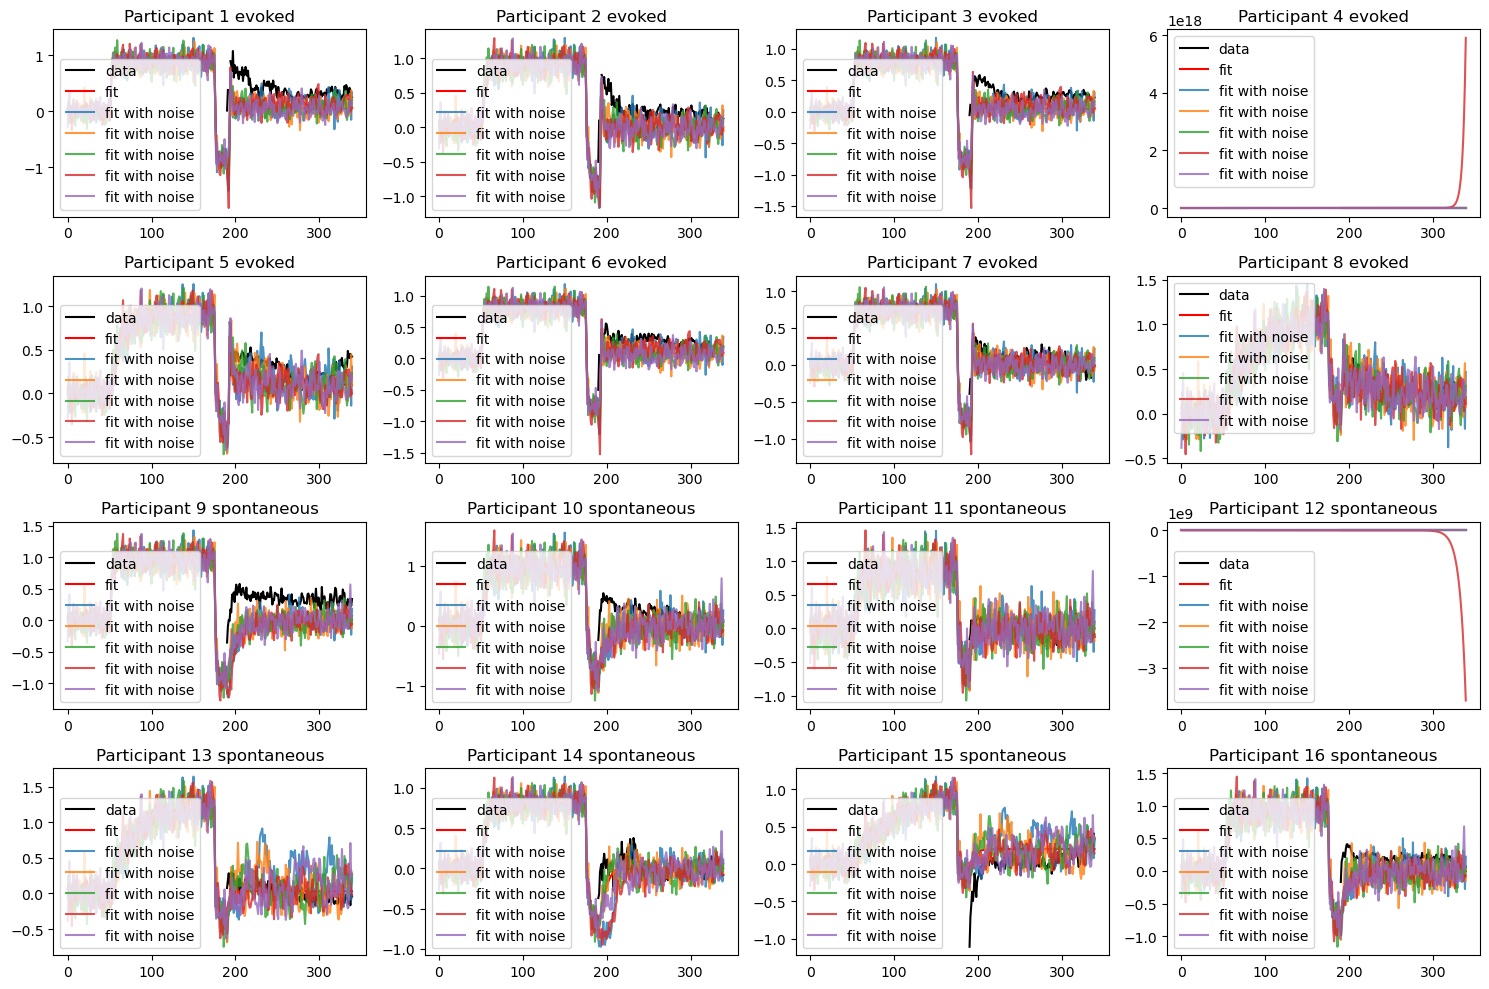

In [22]:
plt.figure(figsize=(15,10))
for k in range(16):
    plt.subplot(4,4,k+1)
    plt.title(f'Participant {k+1} {paradigm_by_id_lut[k]}')
    plt.plot(data[k],label='data',color='black')
    plt.plot(outs[k],label='fit',color='red')
    for n in range(n_trials):
        # plt.plot(outs_noi[k][n],label='fit with noise',color='blue',alpha=0.3)
        plt.plot(outs_noi[k][n],label='fit with noise',alpha=0.8)
    plt.legend()
    plt.tight_layout()
plt.show()

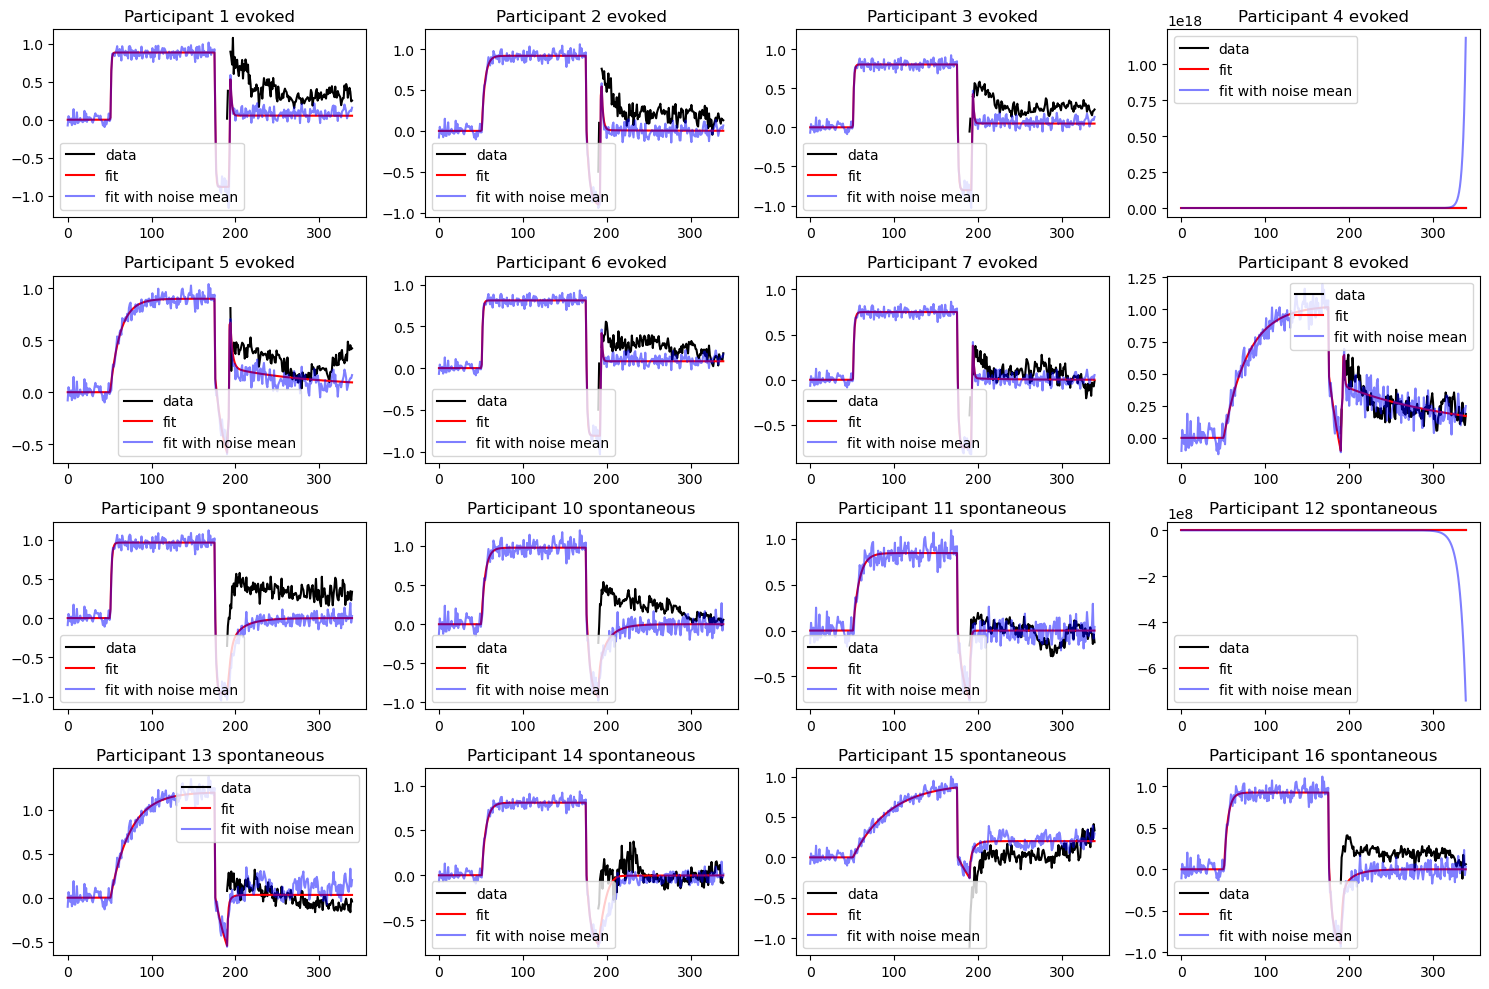

In [23]:
plt.figure(figsize=(15,10))
for k in range(16):
    plt.subplot(4,4,k+1)
    plt.title(f'Participant {k+1} {paradigm_by_id_lut[k]}')
    plt.plot(data[k],label='data',color='black')
    plt.plot(outs[k],label='fit',color='red')
    mean_out = np.mean([outs_noi[k][n]for n in range(n_trials)],axis=0)
    plt.plot(mean_out,label='fit with noise mean',color='blue',alpha=0.5)
        # plt.plot(outs_noi[k][n],label='fit with noise',color='blue',alpha=0.3)
        # plt.plot(,label='fit with noise',alpha=0.8)
    plt.legend()
    plt.tight_layout()
plt.show()

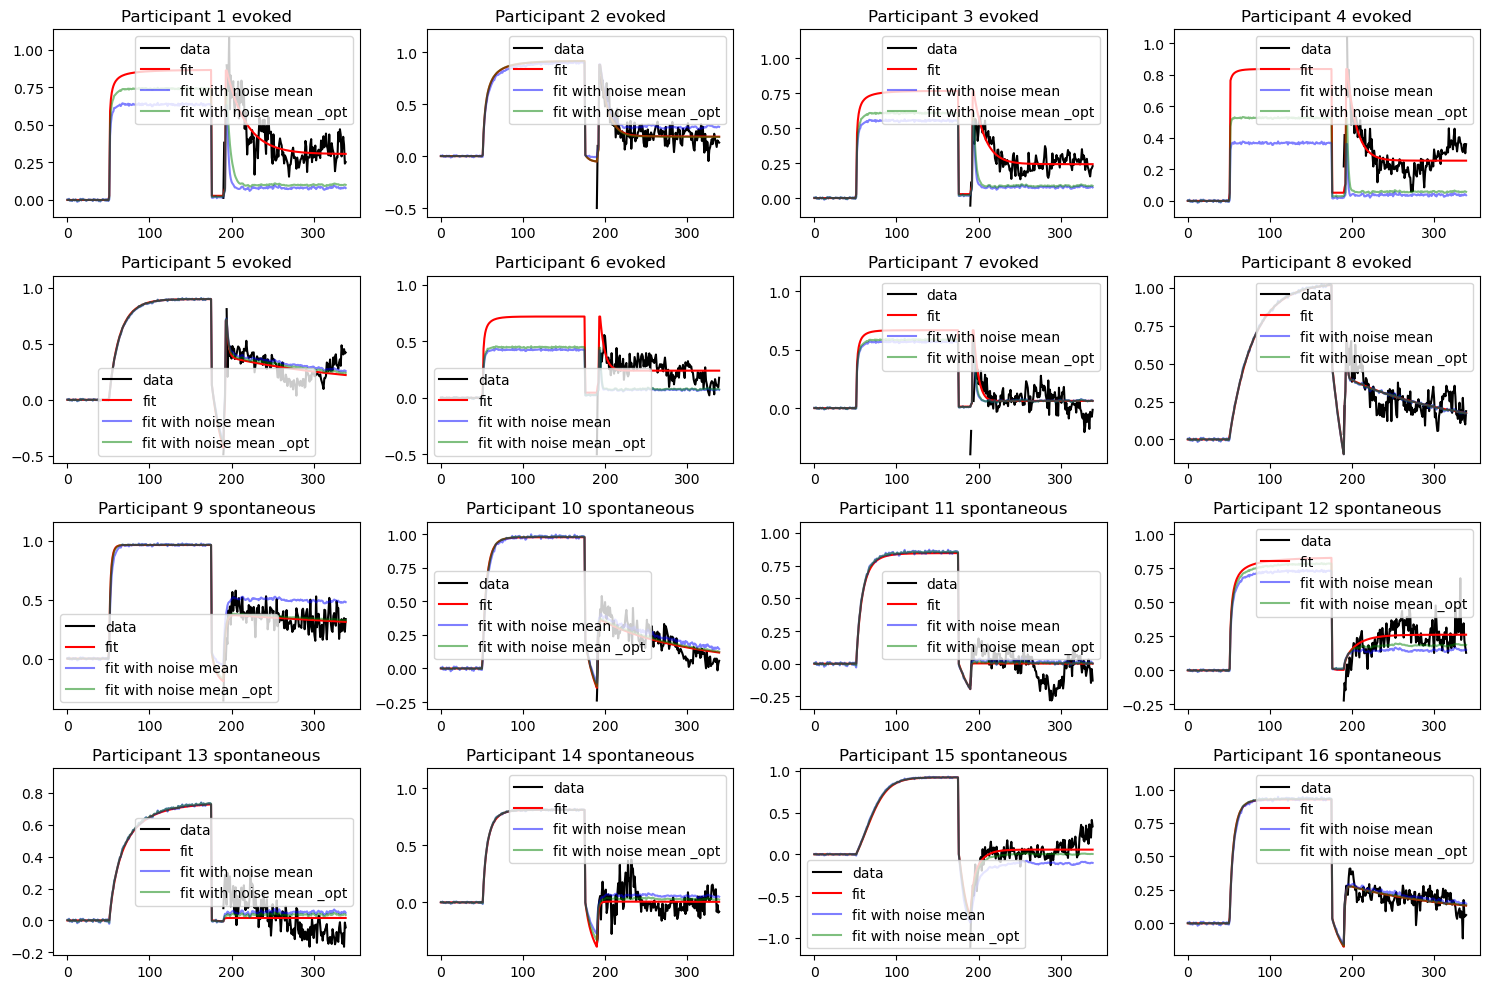

In [96]:
plt.figure(figsize=(15,10))
for k in range(16):
    plt.subplot(4,4,k+1)
    plt.title(f'Participant {k+1} {paradigm_by_id_lut[k]}')
    plt.plot(data[k],label='data',color='black')
    plt.plot(outs[k],label='fit',color='red')
    mean_out = np.mean([outs_noi_u[k][n]for n in range(n_trials)],axis=0)
    mean_out_ = np.mean([outs_noi_u_[k][n]for n in range(n_trials)],axis=0)
    plt.plot(mean_out,label='fit with noise mean',color='blue',alpha=0.5)
    plt.plot(mean_out_,label='fit with noise mean _opt',color='green',alpha=0.5)
        # plt.plot(outs_noi[k][n],label='fit with noise',color='blue',alpha=0.3)
        # plt.plot(,label='fit with noise',alpha=0.8)
    plt.legend()
    plt.tight_layout()
plt.show()

In [58]:
#function that computes noise covariance matrix
#second functon that generates bootstrap covariance matrices
def compute_covariance(y):
    ''''''
    return np.cov(y, rowvar=False)

def generate_bootstrap_covariance(y, n_bootstraps=1000):
    bootstrapped_covs = []
    for _ in range(n_bootstraps):
        bootstrapped_sample = np.random.choice(y, size=len(y), replace=True)
        bootstrapped_covs.append(compute_covariance(bootstrapped_sample))
    return np.array(bootstrapped_covs)

In [59]:
#given a vector y and a covariance martix c compute the log likelihood with respect to a zero mean Gaussian with covariance c
#if y contains nans, ignore those entries and the corresponding rows and columns in c
def log_likelihood(y, c):
    y = np.array(y)
    mask = ~np.isnan(y)
    y = y[mask]
    c = c[np.ix_(mask, mask)]
    n = len(y)
    sign, logdet = np.linalg.slogdet(c)
    if sign <= 0:
        raise ValueError("Covariance matrix is not positive definite")
    inv_c = np.linalg.inv(c)
    ll = -0.5 * (n * np.log(2 * np.pi) + logdet + y.T @ inv_c @ y)
    return ll

In [93]:
#compute output noise vectors as outs_noise_only[k] = outs_noi[k][n] - outs[k], store as a dict over k of lists over n
outs_noise_only = {k: [outs_noi[k][n] - outs[k] for n in range(len(outs_noi[k]))] for k in range(len(outs_noi))}
outs_noise_only_u = {k: [outs_noi_u[k][n] - outs[k] for n in range(len(outs_noi_u[k]))] for k in range(len(outs_noi_u))}
outs_noise_only_u_ = {k: [outs_noi_u_[k][n] - outs[k] for n in range(len(outs_noi_u_[k]))] for k in range(len(outs_noi_u_))}
#similarly compute data error vectors as data_err[k] = data[k] - outs[k]
data_err = {k: data[k] - outs[k] for k in range(len(data))}

In [63]:
#for each k compute covariance matrix of outs_noise_only[k]
#then compute log likelihood of data_err[k] with respect to that covariance matrix
cov_matrices = {}
log_likelihoods = {}
for k in outs_noise_only:
    cov_matrices[k] = compute_covariance(outs_noise_only[k])
    log_likelihoods[k] = log_likelihood(data_err[k], cov_matrices[k])  

print(log_likelihoods)

{0: 123.45165198586284, 1: 123.045830790396, 2: 131.23137293416988, 3: 147.98132142483843, 4: 129.75694549706546, 5: 97.79955257400792, 6: 73.97563433087916, 7: 117.11960101529496, 8: 109.5529497182185, 9: 111.42433791313579, 10: 91.6158569776333, 11: 155.02678794047824, 12: 114.92618617400237, 13: 117.80768446580471, 14: 90.96944012235872, 15: 140.81468475683351}


In [94]:
cov_matrices_u = {k: np.cov(np.array(outs_noise_only_u[k]).T) for k in outs_noise_only_u}
cov_matrices_u_ = {k: np.cov(np.array(outs_noise_only_u_[k]).T) for k in outs_noise_only_u_}

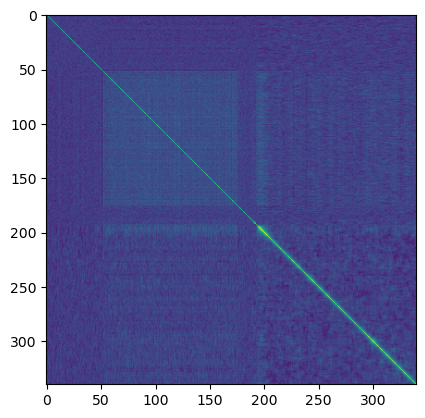

In [71]:
plt.imshow(cov_matrices_u[0])

In [97]:
subject_cov_matrices = {k: [cov_matrices_u[k], np.eye(cov_matrices_u[k].shape[0])] for k in range(16)}
subject_cov_matrices_ = {k: [cov_matrices_u_[k], np.eye(cov_matrices_u_[k].shape[0])] for k in range(16)}

In [73]:
#given a list of covariance matrices, optimise a weighted sum of them to maximise the log likelihood of the data errors
#withts are parametrised by vector s such that w_i = s_i^2

# a wrapper for an objective function that takes in s and returns the negative log likelihood
def objective_fun_wrapper_cov(cov_matrices, data_err):
    def loss_fun(s):
        s = np.array(s)
        weights = s**2
        combined_cov = sum(w * cov for w, cov in zip(weights, cov_matrices))
        total_ll = log_likelihood(data_err, combined_cov)
        return -total_ll  # we want to maximise log likelihood, so return negative
    return loss_fun

In [76]:
#loop over k, optimise with respect to covariance matrices vector and report the final weights and likelihoods
final_weights = {}
final_likelihoods = {}
for k in range(16):
    print(f'Optimising for k={k}')
    initial_weights = np.ones(len(subject_cov_matrices[k]))
    result = minimize(objective_fun_wrapper_cov(subject_cov_matrices[k], data_err[k]), initial_weights, bounds=[(1e-10, None)] * len(initial_weights))
    final_weights[k] = result.x
    final_likelihoods[k] = -result.fun
    print(f'Final weights for k={k}: {final_weights[k]}')
    print(f'Final log likelihood for k={k}: {final_likelihoods[k]}')

Optimising for k=0
Final weights for k=0: [0.52900987 0.07223235]
Final log likelihood for k=0: 167.2022708252627
Optimising for k=1
Final weights for k=1: [0.12312311 0.09051613]
Final log likelihood for k=1: 157.94703989756795
Optimising for k=2
Final weights for k=2: [0.72598676 0.0597503 ]
Final log likelihood for k=2: 175.24102054340239
Optimising for k=3
Final weights for k=3: [0.57641578 0.06377648]
Final log likelihood for k=3: 180.8991811678761
Optimising for k=4
Final weights for k=4: [0.67285501 0.06267861]
Final log likelihood for k=4: 164.5761481335902
Optimising for k=5
Final weights for k=5: [0.90319273 0.07196314]
Final log likelihood for k=5: 144.52958432348035
Optimising for k=6
Final weights for k=6: [0.82250825 0.08522998]
Final log likelihood for k=6: 132.27016949526086
Optimising for k=7
Final weights for k=7: [0.52686956 0.0739099 ]
Final log likelihood for k=7: 153.82288777089798
Optimising for k=8
Final weights for k=8: [0.26101205 0.08312822]
Final log likelih

In [98]:
#loop over k, optimise with respect to covariance matrices vector and report the final weights and likelihoods
final_weights_ = {}
final_likelihoods_ = {}
for k in range(16):
    print(f'Optimising for k={k}')
    initial_weights = np.ones(len(subject_cov_matrices_[k]))
    result = minimize(objective_fun_wrapper_cov(subject_cov_matrices_[k], data_err[k]), initial_weights, bounds=[(1e-10, None)] * len(initial_weights))
    final_weights_[k] = result.x
    final_likelihoods_[k] = -result.fun
    print(f'Final weights for k={k}: {final_weights_[k]}')
    print(f'Final log likelihood for k={k}: {final_likelihoods_[k]}')

Optimising for k=0
Final weights for k=0: [0.883489   0.07069549]
Final log likelihood for k=0: 171.1485624760595
Optimising for k=1
Final weights for k=1: [0.90951896 0.09080915]
Final log likelihood for k=1: 157.74168686294837
Optimising for k=2
Final weights for k=2: [0.96850121 0.0596415 ]
Final log likelihood for k=2: 175.75713959565167
Optimising for k=3
Final weights for k=3: [1.02239363 0.05789391]
Final log likelihood for k=3: 187.35235534518756
Optimising for k=4
Final weights for k=4: [0.99874044 0.06267067]
Final log likelihood for k=4: 164.59252507638422
Optimising for k=5
Final weights for k=5: [0.9903019  0.07154799]
Final log likelihood for k=5: 145.37978390056605
Optimising for k=6
Final weights for k=6: [0.9794434  0.08527578]
Final log likelihood for k=6: 132.70648175388703
Optimising for k=7
Final weights for k=7: [1.00309279 0.07368817]
Final log likelihood for k=7: 153.9306452611939
Optimising for k=8
Final weights for k=8: [1.05078671 0.08307724]
Final log likeli

In [41]:
# #import pickle and store the parameters incl. info that reads: 200 steps local optimization
# with open(f'{ROOT_PATH}/experimental/coin_run062loc_postLocalOpt.pkl','wb') as f:
#     pickle.dump({'opt_data': opt_data, 'opt_params_manu': opt_params_manu, 'outs': outs}, f)

In [28]:
def bic_from_rmse(rmse, n_params, n_samples):
    """
    Calculate Bayesian Information Criterion (BIC) from RMSE.
    
    Parameters:
    rmse (float): Root Mean Square Error.
    n_params (int): Number of parameters in the model.
    n_samples (int): Number of samples in the dataset.
    
    Returns:
    float: BIC value.
    """
    return n_samples * np.log(rmse**2) + n_params * np.log(n_samples)

In [ ]:
# data_np = [val for _,val in data]
# data_np = np.array(data_np)
# #save np file
# for subj,val in data.items():
#     np.save(f'{ROOT_PATH}/results/coin_subj_data_{subj}.npy', val)

In [83]:
subj_rmse_bic = {}
wn_bics = []
for k in opt_params_manu:
    # print(f'Optimized parameters for {k}: {opt_params_manu[k].x}, rmse: {np.sqrt(opt_params_manu[k].fun)}')
    gauss_style_bic = bic_from_rmse(np.sqrt(opt_params_manu[k].fun), 5, np.sum(~np.isnan(data[k])))
    n = int(np.sum(~np.isnan(data[k])))  # = n_samples
    full_bic_white_noise = gauss_style_bic + n * (1.0 + np.log(2*np.pi))
    print(f'Gaussian BIC: {gauss_style_bic}, BIC: {full_bic_white_noise}')
    subj_rmse_bic[k] = {'rmse:': np.sqrt(opt_params_manu[k].fun),
                        'BIC': bic_from_rmse(np.sqrt(opt_params_manu[k].fun), 5, np.sum(~np.isnan(data[k])))}
    wn_bics.append(full_bic_white_noise)

Gaussian BIC: -765.0831205899169, BIC: -296.83340463237494
Gaussian BIC: -757.1896463056862, BIC: -288.93993034814423
Gaussian BIC: -778.3259687015739, BIC: -310.0762527440319
Gaussian BIC: -792.2786965227557, BIC: -324.0289805652137
Gaussian BIC: -723.4068330265551, BIC: -255.1571170690131
Gaussian BIC: -707.4889506433581, BIC: -239.2392346858161
Gaussian BIC: -682.7317905794637, BIC: -214.4820746219217
Gaussian BIC: -742.441407062518, BIC: -274.19169110497603
Gaussian BIC: -774.4280290543215, BIC: -300.5025589639609
Gaussian BIC: -843.250285438961, BIC: -369.32481534860034
Gaussian BIC: -732.8451720423324, BIC: -258.9197019519717
Gaussian BIC: -777.3174093893642, BIC: -303.3919392990036
Gaussian BIC: -714.0248622577368, BIC: -240.09939216737615
Gaussian BIC: -717.9232559121091, BIC: -243.99778582174844
Gaussian BIC: -698.3692058452813, BIC: -224.44373575492062
Gaussian BIC: -885.3851588701845, BIC: -411.4596887798238


In [99]:
opt_noise_bics = []
opt_noise_bics_ = []
for k in range(16):
    mybic = -2*final_likelihoods[k] + 6*np.log(np.sum(~np.isnan(data[k])))
    mybic_ = -2*final_likelihoods_[k] + 6*np.log(np.sum(~np.isnan(data[k])))
    print(f'Final BIC for k={k}: {mybic}')
    print(f'Final BIC for k={k} (opt): {mybic_}')
    opt_noise_bics.append(mybic)
    opt_noise_bics_.append(mybic_)

Final BIC for k=0: -303.7688688071219
Final BIC for k=0 (opt): -311.66145210871554
Final BIC for k=1: -285.2584069517324
Final BIC for k=1 (opt): -284.84770088249326
Final BIC for k=2: -319.8463682434013
Final BIC for k=2 (opt): -320.87860634789985
Final BIC for k=3: -331.1626894923487
Final BIC for k=3 (opt): -344.06903784697164
Final BIC for k=4: -298.51662342377693
Final BIC for k=4 (opt): -298.54937730936496
Final BIC for k=5: -258.4234958035572
Final BIC for k=5 (opt): -260.1238949577286
Final BIC for k=6: -233.90466614711823
Final BIC for k=6 (opt): -234.77729066437058
Final BIC for k=7: -277.0101026983925
Final BIC for k=7 (opt): -277.2256176789843
Final BIC for k=8: -300.2147925548281
Final BIC for k=8 (opt): -299.72970913208417
Final BIC for k=9: -371.88306379729767
Final BIC for k=9 (opt): -371.3629671273001
Final BIC for k=10: -270.855214723638
Final BIC for k=10 (opt): -270.84051244869494
Final BIC for k=11: -331.2575487738673
Final BIC for k=11 (opt): -335.372432551533
Fin

Text(0, 0.5, 'BIC from optimized noise')

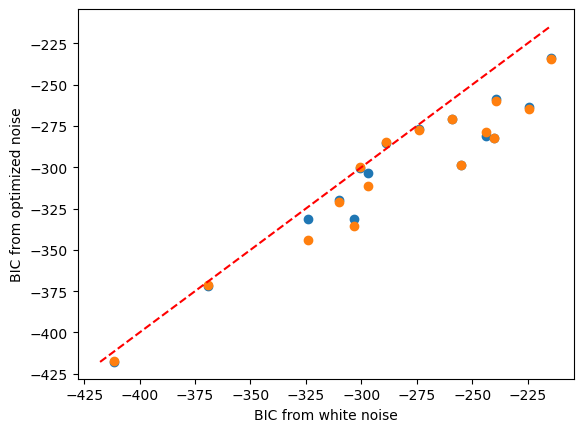

In [ ]:
plt.figure()
plt.plot(wn_bics,opt_noise_bics,'o',label='iter 1')
plt.plot(wn_bics,opt_noise_bics_,'x',label='iter 2')
plt.plot([min(wn_bics+opt_noise_bics), max(wn_bics+opt_noise_bics)], [min(wn_bics+opt_noise_bics), max(wn_bics+opt_noise_bics)], 'r--')
plt.xlabel('BIC from white noise')
plt.ylabel('BIC from optimized noise')

Text(0.5, 1.0, 'subjects -->>1')

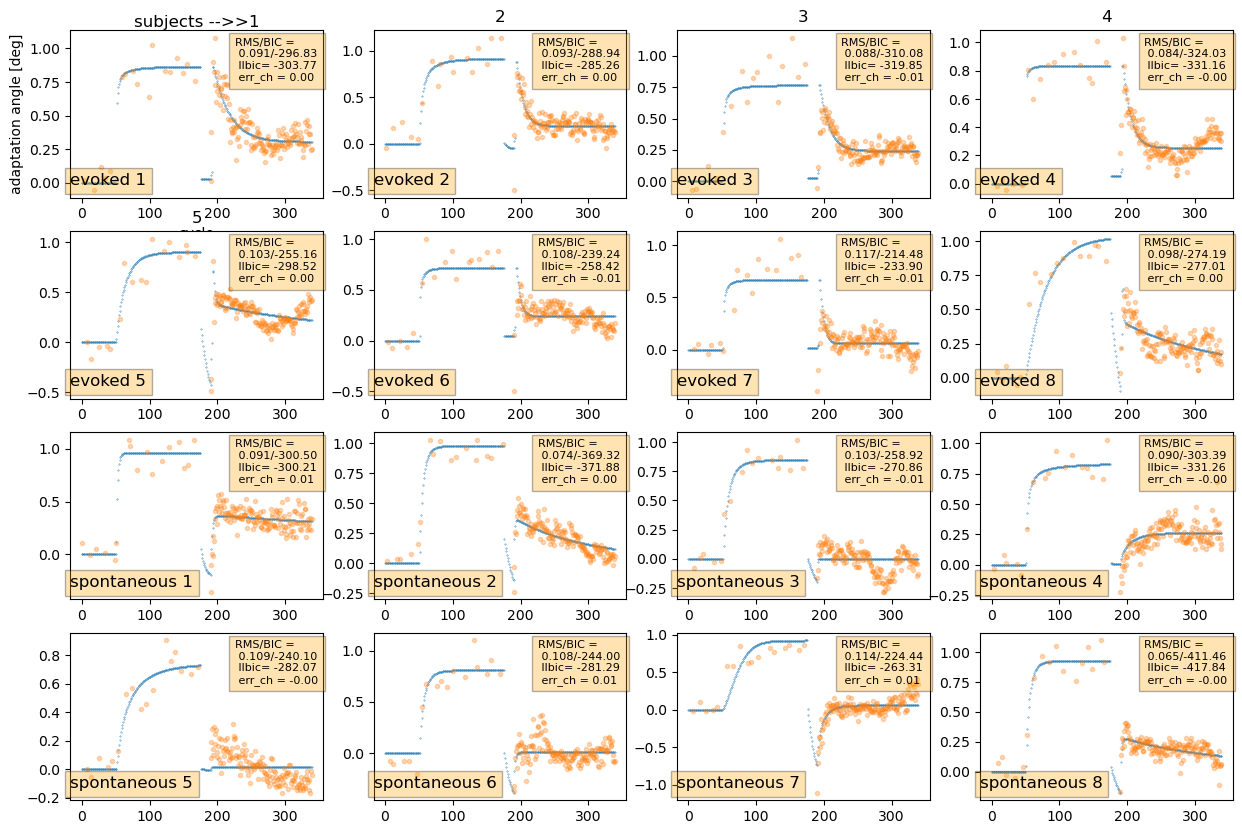

In [89]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    mse = np.nanmean((ydata_model-ydata_experiment)**2)
    rms = np.sqrt(mse)
    bic_value = bic( ydata_experiment,ydata_model, 5)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],'.',linewidth=0.5, markersize=0.6)
    plt.plot(data[k],'.', alpha=0.3)

    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))

    plt.text(0.65, 0.82, f'RMS/BIC =\n {rms:.3f}/{wn_bics[k]:.2f}\n llbic= {opt_noise_bics[k]:.2f} \n err_ch = {np.mean(ydata_experiment[-146:]-ydata_model[-146:]):.2f}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8,
                 bbox=dict(facecolor='orange', alpha=0.3))

plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [30]:
import numpy as np

def bic(measured_data, modeled_data, k_params,
        mode='white_gaussian',
        autoregressive_coeffs=None,
        autoregressive_sigma=None):
    """
    Compute the Bayesian Information Criterion (BIC) for a model fit,
    assuming normally distributed residuals.

    Parameters
    ----------
    measured_data : array-like
        The observed data (y_exp). NaNs here are handled per mode.
    modeled_data : array-like
        The model predictions (y_mod). Must not contain NaNs.
    k_params : int
        The number of free parameters in the model (p).
    mode : str
        'white_gaussian' (default) or 'autoregressive_gaussian'.
    autoregressive_coeffs : array-like, optional
        AR coefficients [a1, a2, …, ap] for the noise. Required if mode='autoregressive_gaussian'.
    autoregressive_sigma : float, optional
        Known noise standard deviation (\sigma). If None, estimated from data.

    Returns
    -------
    float
        The BIC value.
    """
    # 0) validate model output
    y_mod = np.asarray(modeled_data)
    if np.isnan(y_mod).any():
        raise ValueError("modeled_data contains NaN values; cannot proceed.")

    # 1) white‐noise Gaussian branch
    if mode == 'white_gaussian':
        y_exp = np.asarray(measured_data)
        mask = ~np.isnan(y_exp)
        y_exp_clean = y_exp[mask]
        y_mod_clean = y_mod[mask]

        n = y_exp_clean.size
        if n == 0:
            raise ValueError("No valid data points: all measured_data are NaN.")

        rss = np.sum((y_mod_clean - y_exp_clean) ** 2)
        return n * np.log(rss / n) + k_params * np.log(n)

    # 2) autoregressive‐noise Gaussian branch
    elif mode == 'autoregressive_gaussian':
        if autoregressive_coeffs is None:
            raise ValueError("autoregressive_coeffs must be provided for AR mode.")

        a = np.asarray(autoregressive_coeffs)
        p = a.size

        # 2a) handle missing data by zero‐imputation
        y_exp = np.asarray(measured_data)

        # 2b) raw residual series n_t = y_exp - y_mod
        n_series = y_exp - y_mod


        # 2c) pad the first p lags with zeros so we keep N innovations
        pad = np.zeros(p)
        N = n_series.size
        n_padded = np.concatenate([pad, n_series])
        valid_mask = ~np.isnan(n_padded)
        # 2d) compute innovations η_t = n_t - sum(a_i * n_{t-i})
        eta = np.empty(N)
        for t in range(p, p + N):
            #evolution
            evolution = np.dot(a, n_padded[t - p:t][::-1])
            if not valid_mask[t]: # if no observation supplied use evolution
                n_padded[t] = evolution
            #innovations
            eta[t - p] = n_padded[t] - evolution

        # 3) effective sample size and RSS
        valid_mask = valid_mask[p:]  # valid mask for innovations after padding
        eta_valid = eta[valid_mask]
        # print(n_padded)
        # print(eta_valid)
        n_eff = eta_valid.shape[0]
        rss_ar = np.sum(eta_valid ** 2)

        # 4) noise variance 
        if autoregressive_sigma is not None:
            sigma2 = autoregressive_sigma ** 2
            raise NotImplementedError("BIC for AR with known sigma is not implemented yet.")
        else:
            sigma2 = rss_ar / n_eff

        # 5) BIC formula
        bic_value = n_eff * np.log(rss_ar / n_eff) + k_params * np.log(n_eff)
        return bic_value

    else:
        raise ValueError(f"Unknown mode '{mode}'.")


In [31]:
for k in opt_params_manu:
    print(f'BIC: {bic(data[k], outs[k], 5, mode="white_gaussian")}')
    print(f'BICar: {bic(data[k], outs[k], 5, mode="autoregressive_gaussian", autoregressive_coeffs=[0.4])}')
    # subj_rmse_bic[k]['BIC'] = bic(data[k], outs[k], 5, mode='white_gaussian')

BIC: -765.0831205899169
BICar: -778.231101156071
BIC: -757.1896463056862
BICar: -752.4921878203921
BIC: -778.3259687015739
BICar: -814.7742554400554
BIC: -792.2786965227557
BICar: -846.9053752862795
BIC: -723.4068330265551
BICar: -787.4199473122701
BIC: -707.4889506433581
BICar: -749.3668312844608
BIC: -682.7317905794637
BICar: -723.4823937031397
BIC: -742.441407062518
BICar: -781.8611000089685
BIC: -774.4280290543215
BICar: -786.616431103749
BIC: -843.250285438961
BICar: -893.7852604379608
BIC: -732.8451720423321
BICar: -834.6319180990696
BIC: -777.3174093893642
BICar: -809.1589727845101
BIC: -714.0248622577368
BICar: -798.8652456840683
BIC: -717.9232559121091
BICar: -750.6691683475053
BIC: -698.3692058452813
BICar: -736.7465371701479
BIC: -885.3851588701845
BICar: -915.5263296712042


In [32]:
import pickle
# with open(f'{ROOT_PATH}/experimental/subj_rmse_bic_clNN5p.pkl', 'wb') as f:
#     pickle.dump(subj_rmse_bic, f)

In [33]:
subj_rmse_bic_ar = {}
for k in opt_params_manu:
    # print(f'Optimized parameters for {k}: {opt_params_manu[k].x}, rmse: {np.sqrt(opt_params_manu[k].fun)}')
    print(f'BIC: {bic(data[k], outs[k], 5, mode="autoregressive_gaussian", autoregressive_coeffs=[0.4])}')
    subj_rmse_bic_ar[k] = {'rmse:': np.sqrt(opt_params_manu[k].fun),
                        'BIC':bic(data[k], outs[k], 5, mode="autoregressive_gaussian", autoregressive_coeffs=[0.4])}

BIC: -778.231101156071
BIC: -752.4921878203921
BIC: -814.7742554400554
BIC: -846.9053752862795
BIC: -787.4199473122701
BIC: -749.3668312844608
BIC: -723.4823937031397
BIC: -781.8611000089685
BIC: -786.616431103749
BIC: -893.7852604379608
BIC: -834.6319180990696
BIC: -809.1589727845101
BIC: -798.8652456840683
BIC: -750.6691683475053
BIC: -736.7465371701479
BIC: -915.5263296712042


In [34]:
with open(f'{ROOT_PATH}/experimental/subj_rmse_bic_clNN5p_ar.pkl', 'wb') as f:
    pickle.dump(subj_rmse_bic_ar, f)

Text(0.5, 1.0, 'subjects -->>1')

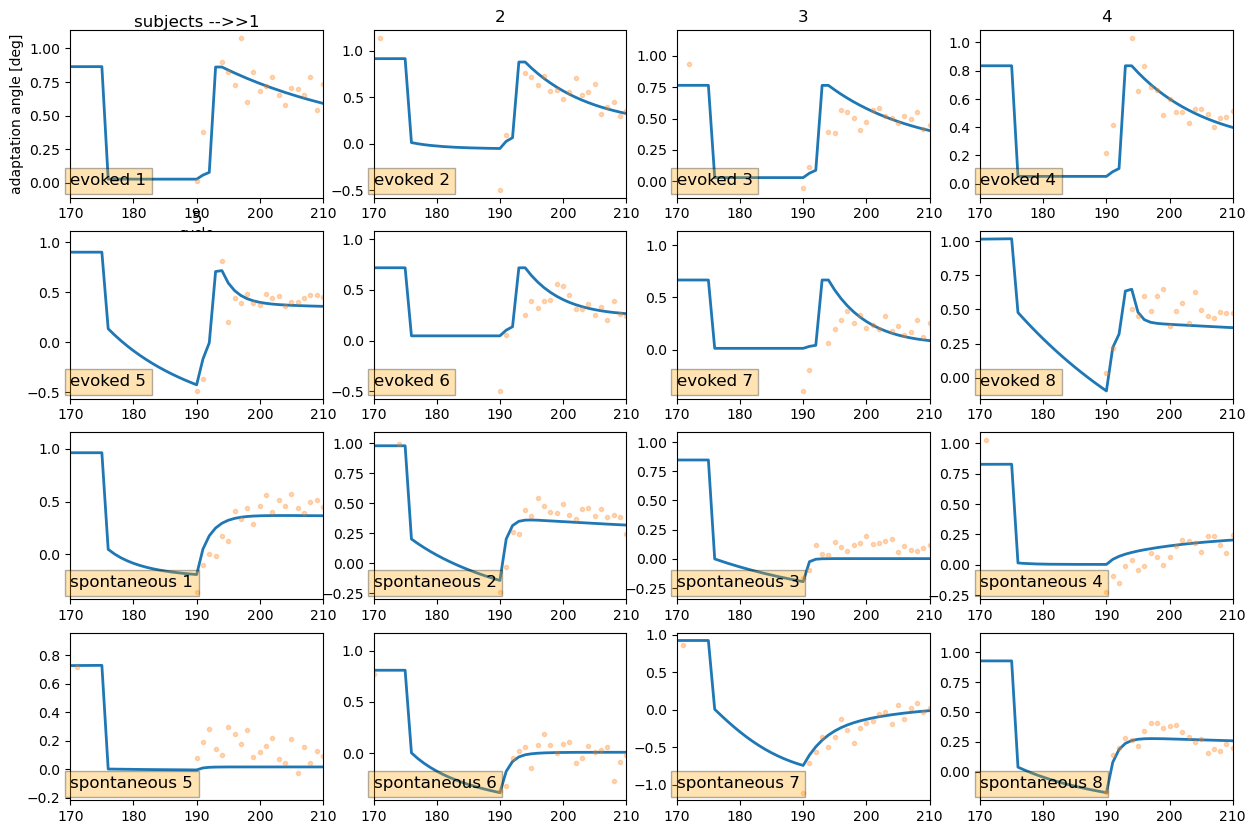

In [35]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    mse = np.nanmean((ydata_model-ydata_experiment)**2)
    rms = np.sqrt(mse)
    bic_value = bic( ydata_experiment,ydata_model, 4)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    plt.xlim([170,210])

    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))

    # plt.text(0.6, 0.2, f'RMS/BIC =\n {rms:.2f}/{bic_value:.2f}', 
    #              horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
    #              bbox=dict(facecolor='orange', alpha=0.3))

plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [36]:
raise ValueError('stop here')

ValueError: stop here

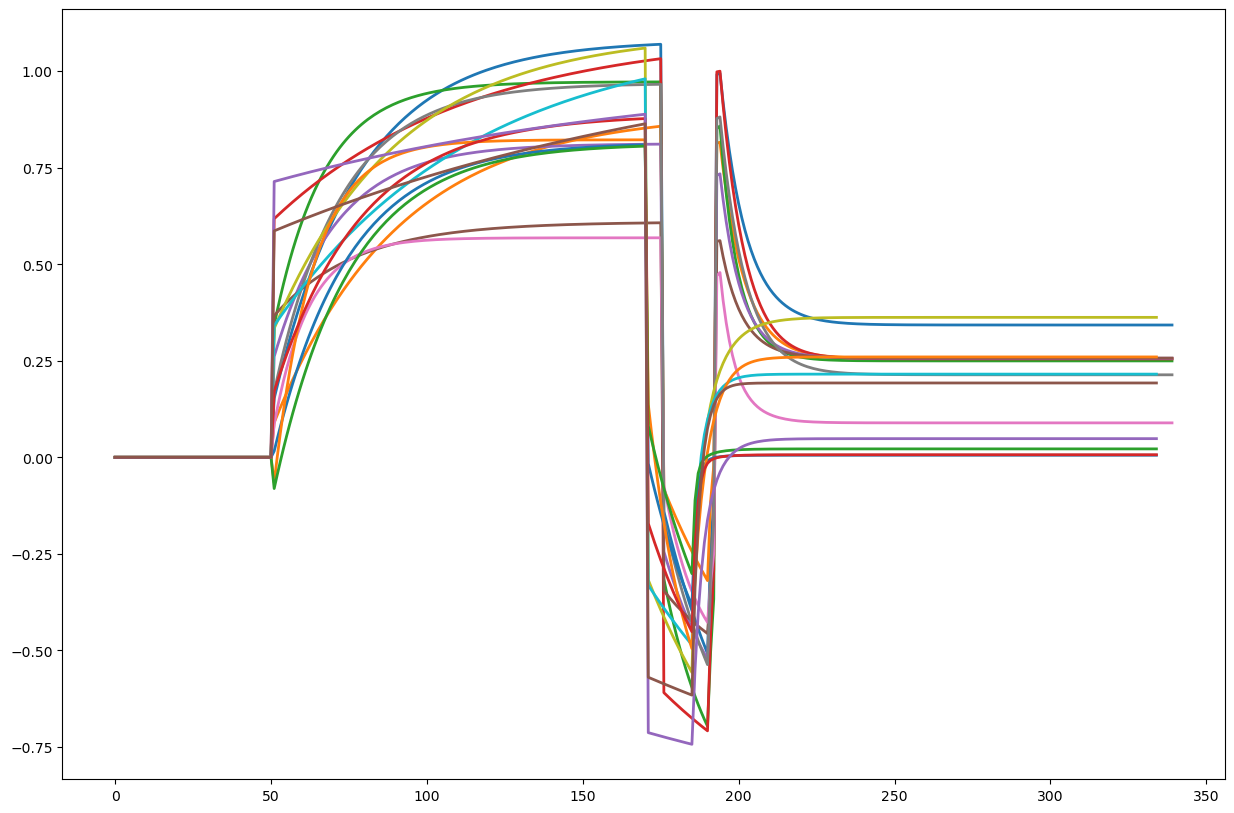

In [ ]:
plt.figure(figsize=(15,10))
for k in opt_data:
    # plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    # plt.plot(data[k],'.', alpha=0.3)
    # if k<5: plt.title(f'{k+1}')
    # plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
    #              horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
    #              bbox=dict(facecolor='orange', alpha=0.3))



# plt.subplot(4,4,1)
# # plt.ylabel('adaptation angle [deg]')
# # plt.xlabel('cycle')

# plt.gca().set_title(f'subjects -->>{1}', pad=-30)

In [ ]:
TaN=150
TaB=120

ref_antero_playlist = {'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'AB4':[(P0, TaN),(Pplus,230),(Pminus, TaB)],
'AB5':[(P0, TaN),(Pplus,410),(Pminus, TaB)]}

antero   = {aa: [ wrapped_runner(aa_item,opt_params_manu[k]['x']) for k in opt_params_manu] for aa,aa_item in ref_antero_playlist.items()}

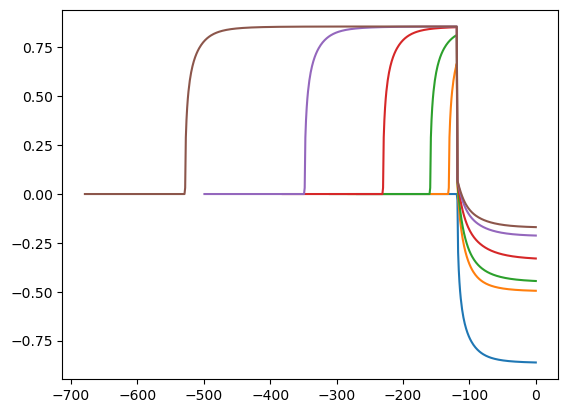

In [ ]:
for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

In [ ]:
frog_ens = [True,False]
Tfrog = 400
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

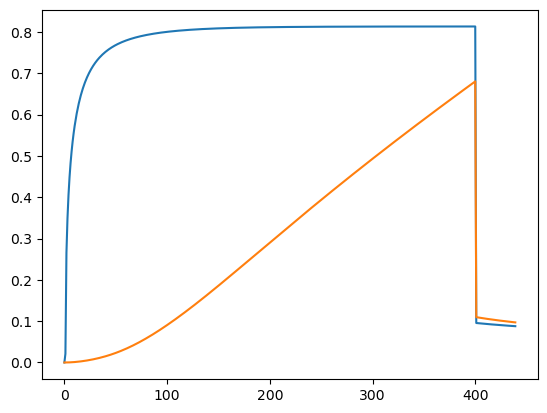

In [ ]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [ ]:
from siggen_utils import herzfeld_block


def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
hrz_playlist =  generate_herzfeld_scenarios(**hrz_params)
# her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

In [ ]:
her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

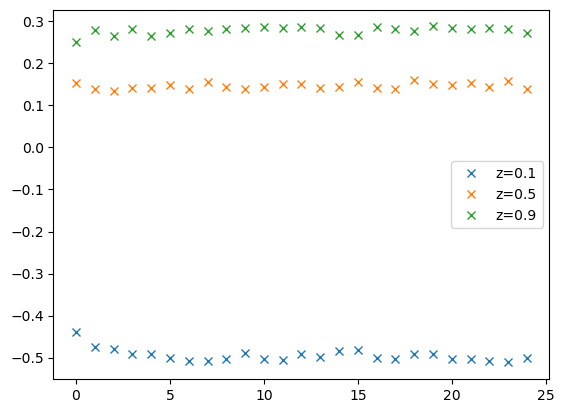

In [ ]:
for iz, z in enumerate(hrz_params['z_list']):
    deltas = []
    mm = lambda x: np.mean(x,axis=0)
    scenario = f'herzfeld,z={z}'
    this_result = her_results[scenario]
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = hrz_playlist[scenario][bb][-1]
        pointer += block_length
        deltas.append(mm(her_results[scenario])[pointer-1]-mm(her_results[scenario])[pointer-3])            

    plt.plot(deltas,'x',label = f'z={z}')
plt.legend()

# for frog_en in frog_ens:
#     plt.plot(np.mean(frogs[frog_en],axis=0))

In [ ]:
playlist = {'Ac':[(P0, 200),(Pplus, 200),(Pchannel,200)],
            'ABc':[(P0, 200),(Pplus, 200),(Pminus, 200),(Pchannel,200)]}

results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in playlist.items()}

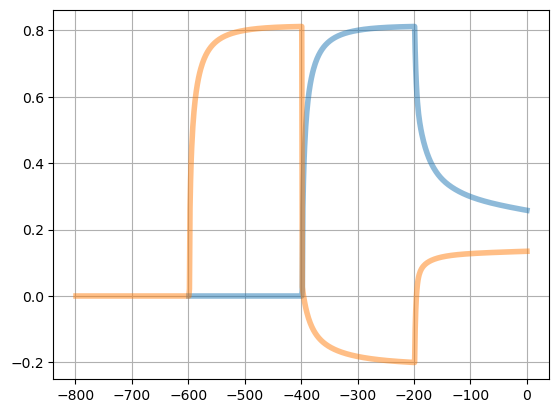

In [ ]:
for aa,aa_item in results.items():
    y = np.mean(results[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y, linewidth=4, alpha=0.5)
plt.grid()

In [ ]:
from dsp_utils import parse_samples

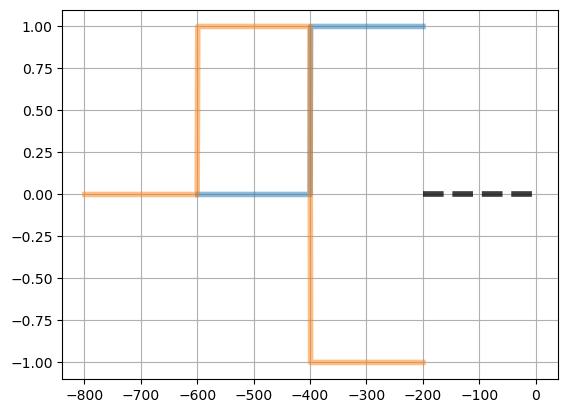

In [ ]:
for aa,aa_item in playlist.items():
    y = parse_samples(playlist[aa])
    x = np.arange(len(y))
    x = x - x[-1]    
    plt.plot(x,y, linewidth=4, alpha=0.5)
    #get a vector where nans replaced by 0 and every non-nan replaced by nan
    y_nan = np.nan*np.ones(len(y))
    y_nan[np.isnan(y)] = 0
    plt.plot(x,y_nan, 'k--',linewidth=4, alpha=0.5)
plt.grid()

In [42]:
matlab100runsBICs = np.genfromtxt('/homes/ar2342/frogs_project/coinBICs100r1000p.csv',delimiter=',')

In [43]:
matlab100runsBICs

array([-790.09984875, -863.39724198, -749.95594134, -754.8596962 ,
       -798.08504629, -714.97407633, -740.19869657, -871.47360159,
       -754.41581871, -769.47342934, -820.16986844, -791.15914063,
       -722.26007708, -735.06819984, -748.22353459, -796.60230946])